In [1]:
import numpy as np
import pandas as pd
import timeit
%alias_magic t timeit

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


# Data

Importing our data, Including X and Y matrices.

for each particle: 

X = $(\delta(rc=0.8),
      \delta(rc=1.2),
      ...,
      \delta(rc=4.8),
      v^2 ) $
      
Y = 0 or 1

In [2]:
data = pd.read_csv(r'C:\Users\Saba\Documents\ML project\Full_particle_Data\Features60(δ).csv')

X, Y = data.iloc[:,2:], data['In_halo']
print(X)
print(Y)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, random_state= 0)

print(len(X_train))
print(len(X_test))
print(len(Y))

       den_rc=0.8  den_rc=1.2  den_rc=1.6  den_rc=2  den_rc=2.4  den_rc=2.8  \
0       -0.000684   -0.020199   -0.011283 -0.012361   -0.011563   -0.012744   
1        0.002344   -0.016610   -0.007876 -0.009066   -0.011563   -0.012108   
2        0.002344   -0.022891   -0.014311 -0.011973   -0.008759   -0.007518   
3       -0.003712   -0.015713   -0.015447 -0.013330   -0.012124   -0.013662   
4        0.014457   -0.013021   -0.010526 -0.009648   -0.009545   -0.009848   
...           ...         ...         ...       ...         ...         ...   
59995   -0.018854   -0.033658   -0.028695 -0.019338   -0.016386   -0.014015   
59996    0.005372   -0.022891   -0.013176 -0.018950   -0.013021   -0.011755   
59997   -0.027938   -0.016610   -0.012797 -0.013330   -0.016274   -0.015428   
59998   -0.024910   -0.029172   -0.028317 -0.018369   -0.019863   -0.017406   
59999   -0.079418   -0.039939   -0.033995 -0.023020   -0.018966   -0.015640   

       den_rc=3.2  den_rc=3.6  den_rc=4  den_rc=4.4

In [3]:
#converting the dataframes to numpy arrays

X_test = np.array(X_test)
X_train = np.array(X_train)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)
X = np.array(X)
Y = np.array(Y)

# Training Models

## 3- Random Forests

In [4]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)

%t classifier.fit(X_train , Y_train)

#Testing the classification on the test sample
Y_predict_rf = classifier.predict(X_test)
%t Y_predict_rf = classifier.predict(X_test)
print(len(Y_test))
print(len(Y_predict_rf[Y_predict_rf == 1]))


161 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.5 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15000
7371


***Training time of LG = $150 ms$***

***Prediction time of LG = $7.51ms$***

Visualising the prediction result in a 2-D subspace of our feature space:
First we showed it in the $\delta(rc=0.8)$ versus $\delta(rc=1.2)$ space and then we visualized it in the velocity versus $\delta(rc=1.2)$ space.

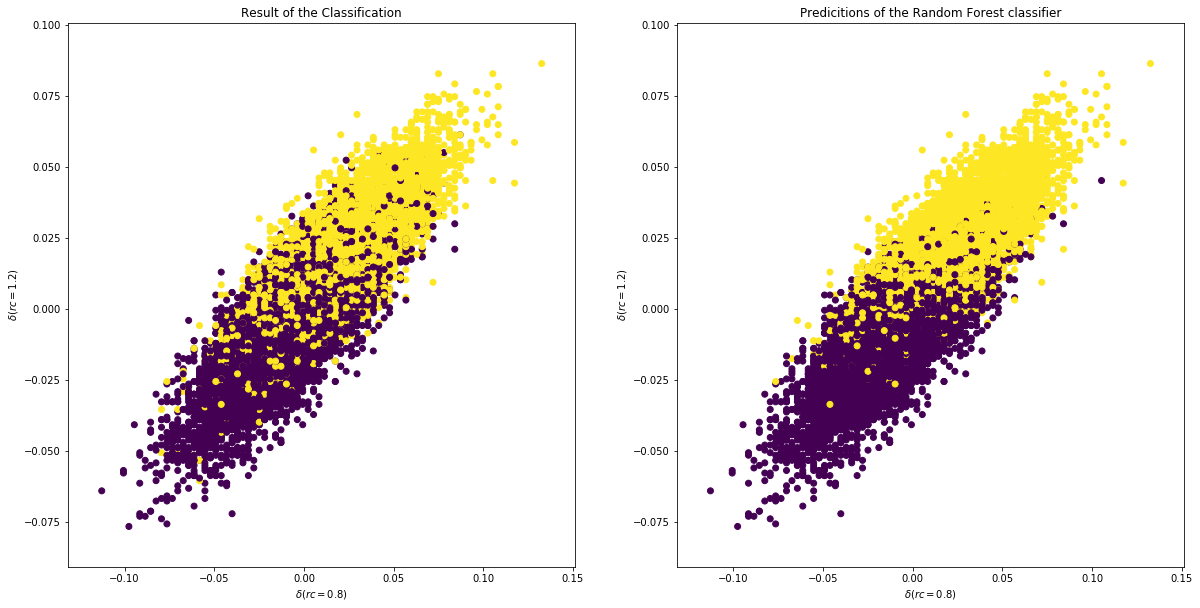

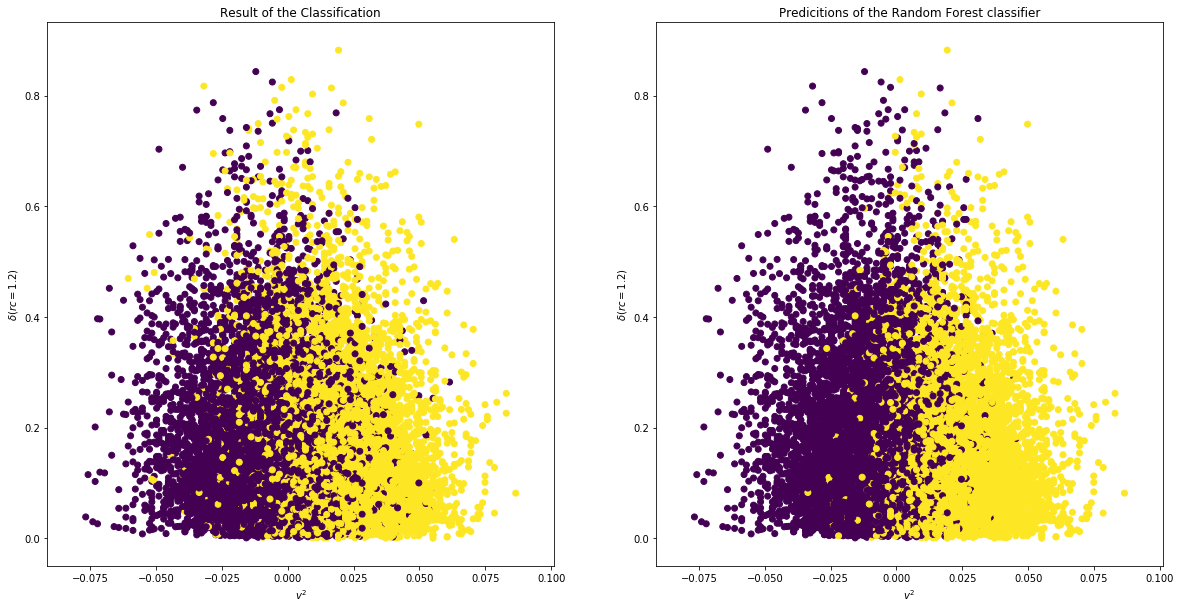

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta(rc=0.8)$', ylabel='$\delta(rc=1.2)$' , title = 'Result of the Classification')

#ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)
ax.scatter(*X_test[:,:2].T, c=Y_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta(rc=0.8)$', ylabel='$\delta(rc=1.2)$' , title = 'Predicitions of the Random Forest classifier')
plt.scatter(*X_test[:,:2].T, c = Y_predict_rf)
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$v^2$', ylabel='$\delta(rc=1.2)$' , title = 'Result of the Classification')

#ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)
ax.scatter(X_test[:,1].T, X_test[:,-1].T , c=Y_test)    

ax = fig.add_subplot(122 , xlabel = '$v^2$', ylabel='$\delta(rc=1.2)$' , title = 'Predicitions of the Random Forest classifier')
plt.scatter(X_test[:,1].T, X_test[:,-1].T , c = Y_predict_rf)
plt.show()

In [7]:
#Over all classification report
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, Y_predict_rf)
print(clf_report)

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      7856
         1.0       0.77      0.80      0.78      7144

    accuracy                           0.79     15000
   macro avg       0.79      0.79      0.79     15000
weighted avg       0.79      0.79      0.79     15000



## Fine Tuning the model:

We should fine tune our model to get the best estimation for this purpose we need to find our hyperparameters.

Important hyperparameters of random forests includes:

n_estimators = number of trees in the foreset

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

As the number of hyperparamethers are quite high we cannot find the optimal value of them by traditional method of validation curve, so for this case we can use the grid search methods.

First we should make a parameter grid to sample from during fitting:

### - Random Hyperparameter Grid

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 12)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In each iteration our algorithm of grid_search will randomly choose each combination of hyperparameters and then it will give us the best parameters of fitting.

### - Grid searching

In [9]:
# Random search of parameters, using 2 fold cross validation, 
# search across 100 different combinations, and use all available cores
print('start')
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)
print(rf_random.best_params_)

start
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 65.5min finished


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


The best fitting over 200 randomly chosen combinations in a grid of size 10*2*12*3*3*2=4320 is as found above like this:

{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Now with these optimal values we can use learning curves for estimating the appropriate training size.

### - Learning Curves

In [10]:
#first we should do the classification with the optimal values.

classifier = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 4, 
                                    max_features = 'sqrt', max_depth = 10, bootstrap = True, random_state=0)


from sklearn.model_selection import learning_curve, validation_curve
import pandas as pd
train_sizes = np.arange(1000,48000,1000)

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= classifier , X = X,
                                                   y = Y, train_sizes = train_sizes, cv = 5, random_state = 0)

print('Training scores:\n\n', pd.DataFrame( train_scores) )

print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

Training scores:

            0         1         2         3         4
0   0.905000  0.932000  0.932000  0.932000  0.932000
1   0.868500  0.937500  0.937500  0.937500  0.937500
2   0.870333  0.933000  0.933000  0.933000  0.933000
3   0.866750  0.923500  0.923500  0.923500  0.923500
4   0.868600  0.906200  0.906200  0.906200  0.906200
5   0.871667  0.898000  0.898000  0.898000  0.898000
6   0.863000  0.890571  0.890571  0.890571  0.890571
7   0.859625  0.885625  0.885625  0.885625  0.885625
8   0.858444  0.884000  0.884000  0.884000  0.884000
9   0.851400  0.881500  0.881500  0.881500  0.881500
10  0.848636  0.874364  0.874364  0.874364  0.874364
11  0.845667  0.873833  0.869417  0.869417  0.869417
12  0.845692  0.871000  0.860769  0.860769  0.860769
13  0.843429  0.866857  0.856429  0.856429  0.856429
14  0.841067  0.862000  0.852867  0.852867  0.852867
15  0.838500  0.858375  0.852062  0.852062  0.852062
16  0.836647  0.857176  0.851706  0.851706  0.851706
17  0.832556  0.852222  0.8

[0.9266     0.9237     0.92046667 0.91215    0.89868    0.89273333
 0.88505714 0.880425   0.87888889 0.87548    0.86921818 0.86555
 0.8598     0.85591429 0.85233333 0.8506125  0.84978824 0.84788889
 0.84541053 0.84336    0.84308571 0.83962727 0.83950435 0.838375
 0.837064   0.83657692 0.83623704 0.83614286 0.83587586 0.8341
 0.83533548 0.8335375  0.83286061 0.83330588 0.83316    0.83229444
 0.83158378 0.83084211 0.83167692 0.83255    0.83325366 0.83307619
 0.83233023 0.83292273 0.83139556 0.8313087  0.8316766 ]
[0.77318443 0.78060056 0.78596716 0.79221719 0.79363384 0.79330051
 0.79338385 0.79503374 0.79465037 0.79520043 0.79538379 0.79665054
 0.79655055 0.79615051 0.79591719 0.79616713 0.79668386 0.7975505
 0.79750048 0.79691718 0.79635052 0.7964505  0.79628381 0.79598384
 0.79653387 0.79518386 0.79498389 0.79515055 0.79560053 0.79610052
 0.79635051 0.79638385 0.79650051 0.7962338  0.79548381 0.79578383
 0.79628386 0.7966672  0.79630053 0.79613384 0.79680051 0.79721717
 0.79738383 0.7

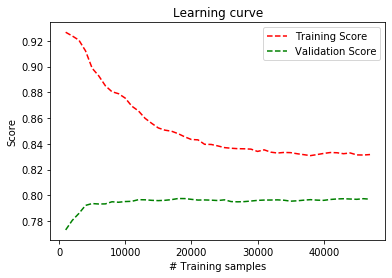

In [11]:
train_scores_mean = train_scores.mean(axis = 1)
print(train_scores_mean)
validation_scores_mean = validation_scores.mean(axis = 1)
print(validation_scores_mean)

plt.title('Learning curve')
plt.plot(ns_list, train_scores_mean,'r--',label = 'Training Score')
plt.plot(ns_list, validation_scores_mean, 'g--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

This learning curve shows us that the good sample size which reduce the overfitting and has a high score is around #training sample = 35000.
but again like previous models we see a bit of bias in the results as can be figured out from the difference between validation score and training score.

Now we should do the train with this number of samples:

In [12]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y , train_size = 35000 , random_state= 0)

print(len(X_train))
print(len(X_test))
print(len(Y))

X_test = np.array(X_test)
X_train = np.array(X_train)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)
X = np.array(X)
Y = np.array(Y)

35000
25000
60000


In [13]:
classifier = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 4, 
                                    max_features = 'sqrt', max_depth = 10, bootstrap = True, random_state=0)

%t classifier.fit(X_train , Y_train)

#Testing the classification on the test sample
Y_predict_rf = classifier.predict(X_test)
%t Y_predict_rf = classifier.predict(X_test)
print(len(Y_test))
print(len(Y_predict_rf[Y_predict_rf == 1]))

46.9 s ± 856 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.05 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25000
12239


Looking at the validation of our tunned model shows us that we had about 1% increase in the accuracy from before. 

In [15]:
#Evaluating the new trained model:
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, Y_predict_rf)
print(clf_report)

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81     13128
         1.0       0.78      0.81      0.80     11872

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



## Feature Importance:

Random forests give us a great tool to estimate the importance of the each feature that we ae using in the classification problem and this task will give us quite great physical explanation of the most important features in our problem.

Here we computed the feature importances in this problem:

In [24]:
importance = classifier.feature_importances_
print(importance)

[0.01640135 0.05388469 0.12531302 0.18975929 0.19223108 0.13579046
 0.08788107 0.06731743 0.03246507 0.02571287 0.02186688 0.05137679]


As we can see the velocity which is our last feature has small contribution in forming the classification.

A histogram of the importance of densities in different cut-offs is also showed below:

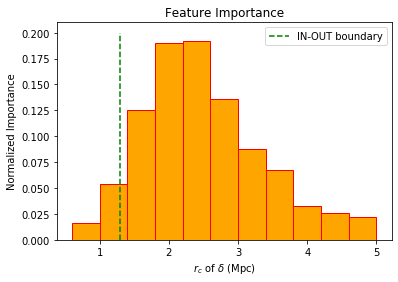

In [42]:
delta = np.array([0.8 , 1.2 , 1.6 , 2 , 2.4 , 2.8 , 3.2 , 3.6 , 4 , 4.4 , 4.8])
importance = np.array([0.01640135, 0.05388469, 0.12531302, 0.18975929, 0.19223108, 0.13579046,
 0.08788107, 0.06731743, 0.03246507, 0.02571287, 0.02186688])

plt.title('Feature Importance')
plt.bar(delta , importance, width = 0.4 , color = 'orange',edgecolor = 'red', capsize =0, linewidth = 1)
plt.vlines(1.3, 0 , 0.2 , color = 'green', linestyles = 'dashed' , label = "IN-OUT boundary")
plt.xlabel('$r_c$ of $\delta$ (Mpc)')
plt.ylabel('Normalized Importance')
plt.legend(loc = 'upper right')
plt.show()

## Metrics:
For getting more sense about our classification we can look at the confusion matrix:

### - Confusion matrix

| **True Positive(TP)** || **False Positive(FP)**   |
|------||------|
|   **False Negative(FN)**   || **True Negative(TN)**|


In [16]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test , Y_predict_rf)
print('Here is the confusion matrix for the LG classifier: \n'  )
print('TP = {}'.format(conf_matrix[0][0]),'  FP = {}'.format(conf_matrix[0][1]) , '\n')
print('FN = {}'.format(conf_matrix[1][0]),'  TN = {}'.format(conf_matrix[1][1]) , '\n')


Here is the confusion matrix for the LG classifier: 

TP = 10483   FP = 2645 

FN = 2278   TN = 9594 



Confusion matrix, without normalization
[[10483  2645]
 [ 2278  9594]]
Normalized confusion matrix
[[0.79852224 0.20147776]
 [0.19188005 0.80811995]]


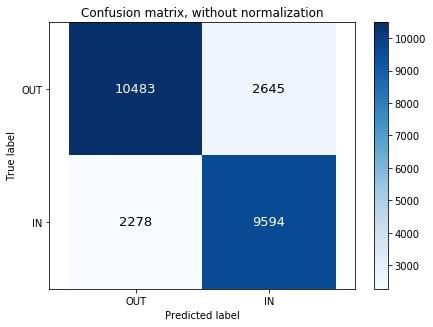

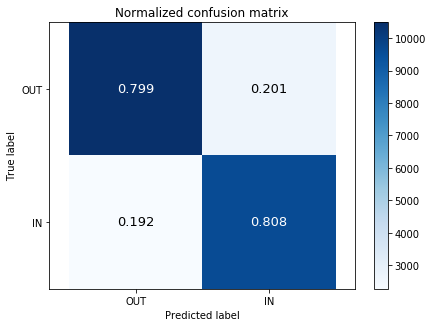

In [17]:
import itertools

class_names = {'IN' , 'OUT'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    #, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),
                 horizontalalignment='center',
                 verticalalignment='center',
                 #transform=ax.transAxes,
                 fontsize = 13,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.axis('equal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We can read the Acurracy from confusion matrix as well, with following formulation:

### - Acurracy  
$Acurracy = \frac{TP + TN}{TP+TN+FP+FN} * 100$ 

Which means the accuracy is the number of correct prediction on the total training size.

In [18]:
acurracy = (conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
print('The accuracy of the model is {}%' .format(round(acurracy*100, 3)))

The accuracy of the model is 80.308%



### - Precision
The fraction of prediction that we got right = $\frac{TP}{TP+FP}$

### - Recall 
The fraction of the instances that were predicted correctly = $\frac{TP}{TP+FN}$


In [19]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(Y_test, Y_predict_rf, pos_label=0)
precision = precision_score(Y_test, Y_predict_rf, pos_label = 0)
print(f"The recall for the LG classifier: \n {round(recall,3)}"  )
print(f"The precision for LG classifier: \n {round(precision,3)}"  )

The recall for the LG classifier: 
 0.799
The precision for LG classifier: 
 0.821


### - F1 score

For looking at the precision and recall at the same time we can use the F$\beta$ score of the model which is defined as:

$F\beta_{score} = \frac{(1+\beta^2).precision.recall}{\beta^2 precision+recall}$

we use F1 score for our purpose:

In [20]:
F1 = 2*precision*recall / (precision+recall)
print('The F1 score is : {}'.format(round(F1,3)))

The F1 score is : 0.81


### - Precision - Recall curve

[[0.72705991 0.27294009]
 [0.58469293 0.41530707]
 [0.9076206  0.0923794 ]
 ...
 [0.89926653 0.10073347]
 [0.60710253 0.39289747]
 [0.58998135 0.41001865]]
[0. 0. 0. ... 0. 0. 0.]


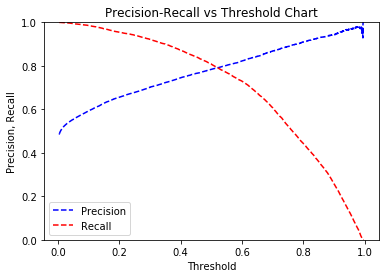

In [21]:
#getting the probability of being in each class from classifier without applying the threshold
Y_probs=classifier.predict_proba(X_test) 
print(Y_probs)
print(Y_predict_rf)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, thresholds = precision_recall_curve(Y_test , Y_probs[:, 1]) 

#retrieve probability of being 1(in second column of Y_prob)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

As can be seen increasing precision will result in decrease of the recall and vice versa.
the trade of point between precision and recall is where the two curves coincides which is around the threshold = 0.5 and will result in precision and recalls equal to 0.8.
so the used 0.5 threshold resulted in the best possible performance of the Logisitc Regression model. and there is no need to change it.

### - ROC curve (Receiver operating characteristic)



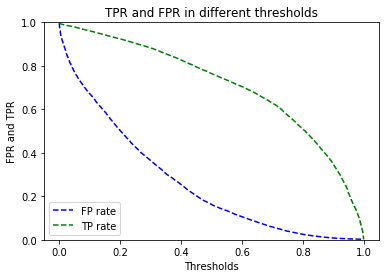

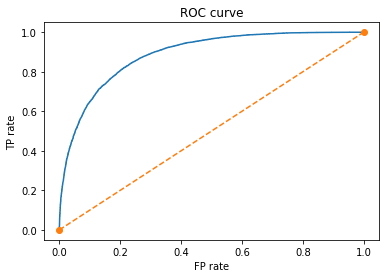

In [22]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_probs[:,1], pos_label=1)

plt.plot(fpr, thresholds , 'b--', label = 'FP rate')
plt.plot(tpr, thresholds , 'g--', label = 'TP rate')
plt.ylabel('FPR and TPR')
plt.xlabel('Thresholds')
plt.title('TPR and FPR in different thresholds')
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()


plt.title('ROC curve')
plt.plot(fpr , tpr)
plt.plot([0, 1], [0, 1] , 'o--')
plt.ylabel('TP rate')
plt.xlabel('FP rate')
plt.show()

The threshold that we choose will result to FPR  arond 0.2 and TPR around 0.8 which again seems to be in the best point possible. lower FPRs will result in lower TPRs as well which we do not like!

### - AUC (Area under ROC curve)
also AUC which is the area under the ROC curve can be another measure which will help and it gives an overal measure of the performance of our model over all thresholds. The ideal AUC should be very close to one, but as wee can see the behaviour of our TPR and FPR is in a way that we cannot get this ideal value and the model has divergence from idealized one.
but we cannot tune our model with the help of AUC.

the value of AUC score for our model is:

In [23]:
from sklearn.metrics import roc_auc_score
print('The AUC score of our LG  is : {}' .format(round(roc_auc_score(Y_test, Y_probs[:,1]),3)))

The AUC score of our LG  is : 0.887


## Over all report:

| *Model* || *Training time* || *prediction time* || *f1 score* || *ROC AUC* || *Accuracy* |
|------||------||------||------||------||------|
| *Random Forest*  || 46.9 $s$ || 3.07 $s$ || 0.81 || 0.887 || 80.308% |